In [1]:
import numpy as np
import physconst as pc
import matplotlib.pyplot as pl
import seaborn

In [7]:
def hernquist_density(r, mass, a):
    """
    :param r:       in kpc
    :param mass:    in Msun
    :param a:       in kpc
    :return:        density in cgs
    """
    roa = r / a
    rho = mass * pc.msun / (2 * np.pi * roa * pow((r + a) * pc.kpc, 3))
    return rho


In [8]:
def hernquist_potential(r, mass, a):
    """
    :param r:       spherical radius in kpc
    :param mass:    in Msun
    :param a:       scale height in kpc
    :return:        potential in (km / s)^2
    """

    phi = -pc.newton * mass * pc.msun / ((r + a) * pc.kpc)

    return phi * 1.e-10


In [9]:
def hernquist_circ_vel(r, mass, a, theta=90):
    """
    :param r:       cylindrical radius in kpc
    :param mass:    total mass in Msun 
    :param a:       scale height in kpc
    :param theta:   viewing angle in deg
    :return:        circular velocity in km / s
    """
    roa = r / a
    vcirc = ( np.sqrt(pc.newton * mass * pc.msun / (a * pc.kpc)) *
              np.sqrt(roa) / (1. + roa) * np.sin(np.deg2rad(theta)) )
    return vcirc * 1.e-5

In [10]:
def isothermal_disc(phi, phi_r0, phi_00, rho0, wturb, rot=0.9):
    """
    :param phi:      potential (r, z) in (km / s)^2
    :param phi_r0:   potential (r, 0) in (km / s)^2  (must be correctly broadcastable with phi)
    :param phi_00:   potential (0, 0) in (km / s)^2  (must be correctly broadcastable with phi)
    :param rho0:     in g / cm^3
    :param wturb:    in km / s
    :param rot:      rotational parameter (no units)
    :return:         density as a function of r in g / cm^3
    """
    rho = rho0 * np.exp(-(phi - rot * rot * phi_r0 - (1. - rot * rot) * phi_00) / (wturb * wturb))
    
    return rho

In [11]:
# This function is not used
def hernquist_column(r, mass, a):
    """
    :param r:       in kpc
    :param mass:    in Msun
    :param a:       in kpc
    :return:        column density at r in cgs
    """
    roa = r / a
    sec_l1 = 1. / np.sqrt(1. - roa * roa) * np.log((1. + np.sqrt(1. - roa * roa)) / roa)
    sec_g1 = 1. / np.sqrt(roa * roa - 1.) * np.arccos(1. / roa)
    sw = np.where(np.less(roa, 1.), sec_l1, sec_g1)
    col = (mass * pc.msun / (2 * np.pi * a * a * pc.kpc * pc.kpc * pow((1. - roa * roa), 2)) *
           ((2. + roa * roa) * sw - 3.))
    return col


In [28]:
# Extents, number of cells, and cell sizes
x1min = x2min = x3min = 0.
x1max = x2max = x3max = 1.
nx1 = nx2 = nx3 = 100
dx1 = (x1max - x1min) / nx1 
dx2 = (x2max - x2min) / nx2
dx3 = (x3max - x3min) / nx3

# Cell centers
x1l = np.linspace(x1min, x1max, nx1, endpoint=False) + dx1 / 2.
x2l = np.linspace(x2min, x2max, nx2, endpoint=False) + dx2 / 2.
x3l = np.linspace(x3min, x3max, nx3, endpoint=False) + dx3 / 2.

# Make broadcastable for 3D calculations
x1 = x1l[None, None, :]
x2 = x2l[None, :, None]
x3 = x3l[:, None, None]

# Create various distance variables, making sure they have shape (nx3, nx2, nx1)
cyl_rad = np.sqrt(x1 * x1 + x2 * x2 + np.zeros_like(x3))
sph_rad = np.sqrt(x1 * x1 + x2 * x2 + x3 * x3)
height = x3 + np.zeros_like(x1) + np.zeros_like(x2)

# Circular velocity projected onto x1-x3 plane
circ_vel = hernquist_circ_vel(cyl_rad, 1.67e11, 2.8) * x1 / cyl_rad

# Hernquist Density profile (used for weighting). Cut out a cylindrical volume.
rho = hernquist_density(sph_rad, 1.67e11, 2.8)
rho = np.where(np.less(cyl_rad, 1.), rho, 1.e-30)
rho = np.where(np.less(np.absolute(height), 0.222), rho, 1.e-30)

# Average over line of sight = y-axis = axis = 1, then across z-axis = axis = 0.
cvav_1, rhosum_1 = np.average(circ_vel, axis=1, weights=rho, returned=True)
cvav_s, rhosum_s = np.average(cvav_1, axis=0, weights=rhosum_1, returned=True)

# Isothermal density profile
phi = hernquist_potential(sph_rad, 1.67e11, 2.8)
phi_r0 = hernquist_potential(cyl_rad, 1.67e11, 2.8)
phi_00 = phi[0, 0, 0]
rho = isothermal_disc(phi, phi_r0, phi_00, 200., 40, 0.9)
rho = np.where(np.less(cyl_rad, 1.), rho, 1.e-30)
rho = np.where(np.less(np.absolute(height), 0.222), rho, 1.e-30)

# Average over line of sight = y-axis = axis = 1, then across z-axis = axis = 0.
icvav_1, irhosum_1 = np.average(circ_vel, axis=1, weights=rho, returned=True)
icvav_s, irhosum_s = np.average(icvav_1, axis=0, weights=irhosum_1, returned=True)

# Same but for density squared
icvav2_1, irhosum2_1 = np.average(circ_vel, axis=1, weights=rho*rho, returned=True)
icvav2_s, irhosum2_s = np.average(icvav2_1, axis=0, weights=irhosum2_1, returned=True)

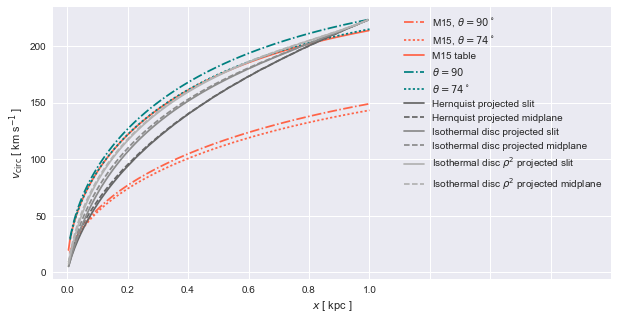

In [51]:
f1 = pl.figure(figsize=(10,5))

# x space for analytic plots
x = np.logspace(-2, 0, 100)

# M15
pl.plot(x, hernquist_circ_vel(x, 1.85e11, 5.), '-.', c='tomato', label=r'M15, $\theta=90^\circ$')
pl.plot(x, hernquist_circ_vel(x, 1.85e11, 5., 74.), ':', c='tomato', label=r'M15, $\theta=74^\circ$')

# M15 table
gr, v = np.loadtxt('rotationCurve.txt', unpack=True, comments='#')
gr *= .232
sl = np.s_[np.less(gr, 1.)]
xt, vt = gr[sl], v[sl]
pl.plot(xt, vt, '-', c='tomato', label=r'M15 table')

# Our profiles
pl.plot(x, hernquist_circ_vel(x, 1.67e11, 2.8), '-.', c='teal', label=r'$\theta=90$')
pl.plot(x, hernquist_circ_vel(x, 1.67e11, 2.8, 74.), ':', c='teal', label=r'$\theta=74^\circ$')

# Our profiles projected
pl.plot(x1[0, 0, :], cvav_s, '-', c='0.4', label=r'Hernquist projected slit')
pl.plot(x1[0, 0, :], cvav_1[0, :], '--', c='0.4', label=r'Hernquist projected midplane')
pl.plot(x1[0, 0, :], icvav_s, '-', c='0.55', label=r'Isothermal disc projected slit')
pl.plot(x1[0, 0, :], icvav_1[0, :], '--', c='0.55', label=r'Isothermal disc projected midplane')
pl.plot(x1[0, 0, :], icvav2_s, '-', c='0.7', label=r'Isothermal disc $\rho^2$ projected slit')
pl.plot(x1[0, 0, :], icvav2_1[0, :], '--', c='0.7', label=r'Isothermal disc $\rho^2$ projected midplane')


# Labels etc
pl.xticks(np.arange(0, 2, 0.2), ['' if i > 1.0 else str(i) for i in np.arange(0, 2, 0.2)])
pl.xlabel(r'$x$ [ kpc ]')
pl.ylabel(r'$v_\mathrm{circ}$ [ km s$^{-1}$ ]')
pl.legend()
pl.show()